In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os

# Changing default dir
os.chdir("/Users/pedroteche/Documents/GitHub/maize-crop-diagnose/")

# Pandas options
pd.set_option("display.max_columns", 500)
# Plotting options
import warnings

warnings.filterwarnings("ignore")

In [25]:
import pyarrow

# Exploring Data

In [38]:
data_dir = "data/raw/"

Text(0.5, 1.0, 'Healthy :(480, 640)')

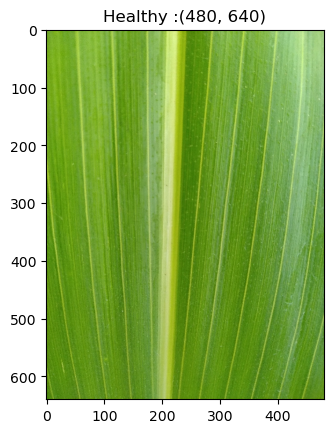

In [39]:
img = tf.keras.utils.load_img("data/raw/healthy/Image_1.jpg")
plt.imshow(img)
plt.title(f"Healthy :{img.size}")

Text(0.5, 1.0, 'MLN: (480, 640)')

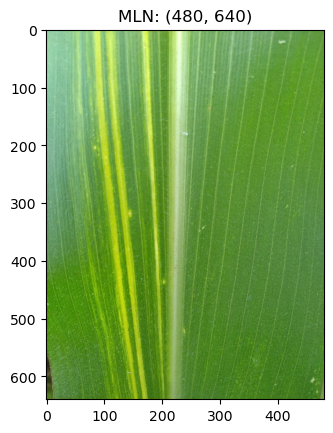

In [40]:
img = tf.keras.utils.load_img("data/raw/mln/Image_1.jpg")
plt.imshow(img)
plt.title(f"MLN: {img.size}")

Text(0.5, 1.0, 'MSV 1: (480, 640)')

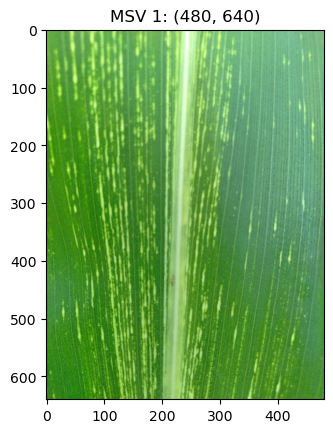

In [41]:
img = tf.keras.utils.load_img("data/raw/msv/Image_1.jpg")
plt.imshow(img)
plt.title(f"MSV 1: {img.size}")

## Removing corrupted images

In [47]:
for subdir, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith(".jpg"):
            try:
                a = Image.open(os.path.join(subdir, file)).load()
            except Exception as e:
                print(f"Image removed: {e}")
                os.remove(os.path.join(subdir, file))
        else:
            print(f"File removed: {file}")
            os.remove(os.path.join(subdir, file))

File removed: .DS_Store
File removed: README.md
File removed: Maize_TZ_Image_Datasheet.pdf
Image removed: image file is truncated (66 bytes not processed)
File removed: .DS_Store
File removed: .DS_Store


## Converting images to TF data

In [48]:
batch_size = 32
img_height = 64 * 2
img_width = 48 * 2


In [49]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 15349 files belonging to 3 classes.
Using 12280 files for training.


In [50]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 15349 files belonging to 3 classes.
Using 3069 files for validation.


In [51]:
class_names = train_ds.class_names
print(class_names)

['healthy', 'mln', 'msv']


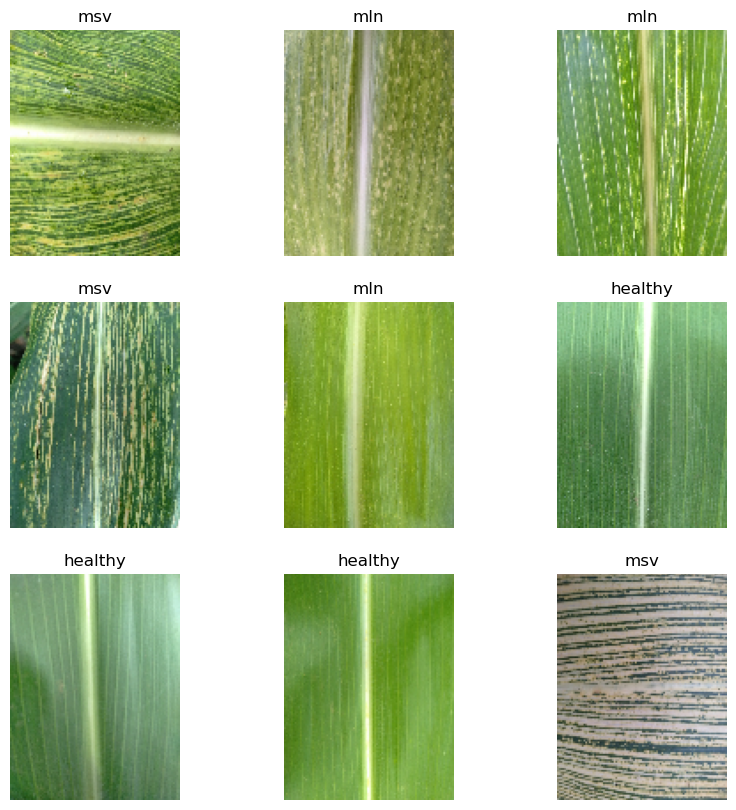

In [52]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [53]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [79]:
num_classes = len(class_names)

model = tf.keras.Sequential(
    [
        tf.keras.layers.Rescaling(1.0 / 255),
        tf.keras.layers.Conv2D(64, 7, activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 5, activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation="softmax"),
    ]
)

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

In [80]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
384/384 [==============================] - 44s 109ms/step - loss: 0.5472 - accuracy: 0.7787 - val_loss: 0.5064 - val_accuracy: 0.7889
Epoch 2/10
384/384 [==============================] - 36s 95ms/step - loss: 0.3592 - accuracy: 0.8616 - val_loss: 0.2644 - val_accuracy: 0.9104
Epoch 3/10
384/384 [==============================] - 37s 95ms/step - loss: 0.2715 - accuracy: 0.9020 - val_loss: 0.2023 - val_accuracy: 0.9277
Epoch 4/10
384/384 [==============================] - 37s 95ms/step - loss: 0.2180 - accuracy: 0.9215 - val_loss: 0.1863 - val_accuracy: 0.9368
Epoch 5/10
384/384 [==============================] - 36s 95ms/step - loss: 0.1952 - accuracy: 0.9279 - val_loss: 0.1504 - val_accuracy: 0.9482
Epoch 6/10
384/384 [==============================] - 37s 95ms/step - loss: 0.1444 - accuracy: 0.9474 - val_loss: 0.1497 - val_accuracy: 0.9492
Epoch 7/10
384/384 [==============================] - 37s 95ms/step - loss: 0.1191 - accuracy: 0.9559 - val_loss: 0.1700 - val_accuracy

<Axes: xlabel='index', ylabel='value'>

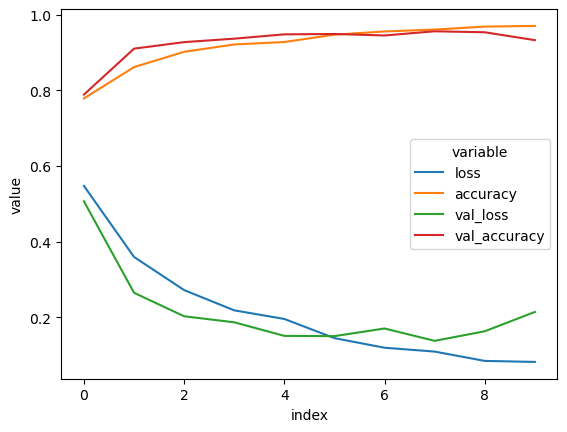

In [82]:
sns.lineplot(data = pd.DataFrame(history.history).reset_index().melt(id_vars = "index"), x = "index", y = "value", hue = "variable")

In [81]:
import seaborn as sns